# Chapter 9: Electrostatics for Salty Solutions

(c) 2018 Manuel Razo. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT). 

---

In [1]:
# Our numerical workhorses
import numpy as np
import scipy as sp
import scipy.signal
import pandas as pd
import mpmath

# Import matplotlib stuff for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D # For 3D plots

# Seaborn, useful for graphics
import seaborn as sns

# Import the default plotting style
import plotting_style as pstyle
# Set plotting style
pstyle.set_plotting_style()

# Function to import and display images from the Garland website
from IPython.display import Image

# Magic function to make matplotlib inline
%matplotlib inline

# This enables SVG graphics inline. 
%config InlineBackend.figure_formats = {'png', 'retina'}

# Define directories
figdir = '../fig/'

## 9.5 A simple model for viral capsid assembly

(c) Carry out a numerical solution for $\phi_n$, $n = 1,2,\ldots,12$, as a function of $\phi_T$ and $\Delta\varepsilon$􏰫. Plot $\phi_n$ as a function of $n$ for
$\phi_T = \phi_C$ and $\Delta\varepsilon = -1, -5,$ and $-10 \; k_BT$. How are the capsomers distributed among the 12 different structures in each of these cases? What happens to the fraction of capsomers in complete capsids as the total volume fraction is varied from below to above $\phi_C$, in the case 􏰫$\Delta\varepsilon = -5 \; k_BT?$

### Solution

As derived earlier in the problem the volume fraction of the partially assembled capsid with $n$ capsomers is of the form
$$
\phi_n = \left( \phi_1 \right)^n e^{- \varepsilon_n / k_BT},
\label{eq_vol_frac}
$$
where $\varepsilon_n$ is the total energy of the interactions between $n$ of the capsomers. This energy is of the form
$$
\varepsilon_n = \sum_{m = 1}^n f_m \Delta\varepsilon,
$$
where $f_m$ is the number of additional contacts between capsomers created when a capsomer binds a structure of size $n - 1$ to form a structure of size $n$. These contacts are listed as
$$
f_n = \begin{cases}
1 \; (n = 2),\\
2 \; (3 \leq n \leq 7),\\
3 \; (8 \leq n \leq 10),\\
4 \; (n = 11),\\
5 \; (n = 12).
\end{cases}
$$

To make things simpler further down let's define a function that computes this energy given a number of capsomers and a value for $\Delta\varepsilon$.

In [2]:
def epsilon_n(Depsilon, n=1):
    '''
    Function that returns the energy of a structure of size n viral capsomers
    in kBT by adding the number of contacts between capsomers with energy 
    Depsilon.
    Parameters
    ----------
    Depsilon: float.
        Energy of interaction between contacts
    n : int. Default 1
        Number of capsomers in structure
    
    Returns
    -------
    Energy of interactions between capsomers in kBT
    '''
    # Create dictionary with number of contacts when adding a new capsomer to
    # a structure of size n - 1 to form a structure of size n
    fn = {1: 0, 
          2: 1, 3: 2, 4: 2, 5: 2, 6: 2, 7: 2,
          8: 3, 9: 3, 10: 3,
          11: 4,
          12: 5}
    
    # Extract the energy of each capsomer contribution
    return np.sum([fn[x] * Depsilon for x in range(1, n + 1)])

In the problem we also derived a relationship for $\phi_C$ the critical volume fraction in which, if we assume that there are only two structures contributing significantly to the volume fraction, these being the single capsomers and the fully assembled dodecahedron, then at this volume fraction half of the capsomers are forming fully formed capsids. This function was found to be of the form
$$
\ln \left( {\phi_C \over 2} \right) = {\varepsilon_{12} \over 11 k_BT}.
$$

Solving for $\phi_C$ this gives
$$
\phi_C = 2 e^{\varepsilon_{12} \over 11 k_BT}.
$$

By assumption at this critical concentration the individual capsomers volume fraction $\phi_1$ and the fully assembled capsids $\phi_{12}$ occupy half of the total volume fraction. Therefore we can use $\phi_C / 2 = \phi_1$ along Eq. \ref{eq_vol_frac} to compute the volume fraction for the other partially assembled capsids. Let's first define a function that computes the volume fraction as given by Eq. \ref{eq_vol_frac}.

In [3]:
def phi_n(Depsilon, n, phi_1):
    '''
    Function that computes the volume fraction occupied by a structure formed
    out of n capsomers given the volume fraction occupied by the single
    monomers in solution.
    Parameters
    ----------
    Depsilon: float.
        Energy of interaction between contacts
    n : int. Default 1
        Number of capsomers in structure
    phi_1 : float [0, 1]
        Volume fraction of individual capsomers
    
    Returns
    -------
    Volume fraction of structure with n capsomers
    '''
    # Compute and return the volume fraction
    return phi_1**n * np.exp(- epsilon_n(Depsilon, n))

With these functions in hand and a value of $\phi_1 = \phi_C / 2$ let's compute the volume fraction for each partially assembled structure.

In [4]:
# Define energies for individual contacts
Depsilon = [-1, -5, -10]

# Define names for columns of tidy data frame
names = ['n', 'Depsilon', 'phi_n', 'phi_c']
# Initialize dataframe
df = pd.DataFrame(columns=names)

# Loop through each binding energy computing the volume fraction of each 
# structure
for de in Depsilon:
    # Define fraction of monomers
    phi_1 = np.exp(epsilon_n(de, 12) / 11)
    # Loop through each individual capsomer
    for n in range(1, 13):
        # Compute the volume fraction
        phi = phi_n(de, n, phi_1)
        # Save results in Series to append to dataframe
        series = pd.Series([n, de, phi, phi_1 * 2], index=names)
        # Append to data frame
        df = df.append(series, ignore_index=True)
        
# Let's look at the dataframe
df.head()

,n,Depsilon,phi_n,phi_c
0,1.0,-1.0,0.071621,0.143242
1,2.0,-1.0,0.013944,0.143242
2,3.0,-1.0,0.007379,0.143242
3,4.0,-1.0,0.003905,0.143242
4,5.0,-1.0,0.002067,0.143242


Let's now plot these fractions

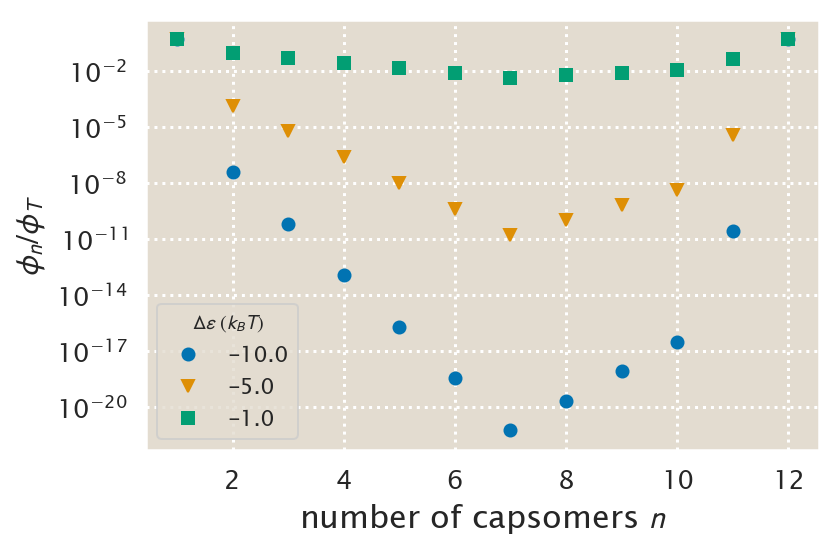

In [5]:
# Group dataframe by energy of single contact
df_group = df.groupby('Depsilon')

# Define markers for each group
markers = ['o', 'v', 's']

# Initialize figure
fig = plt.figure()
# Loop through groups plotting volume fraction
for i, (group, data) in enumerate(df_group):
    plt.plot(data.n, data.phi_n / data.phi_c,
             lw=0, marker=markers[i],
             label=group)
    
# Set y scale to be log
plt.yscale('log')


# Label axis
plt.xlabel(r'number of capsomers $n$')
plt.ylabel(r'$\phi_n / \phi_T$')

# set legend
plt.legend(title=r'$\Delta\varepsilon \; (k_BT)$')

# save figure
plt.tight_layout()
plt.savefig(figdir + 'problem_09_05_01.png', bbox_inches='tight')

Let's now explore for the case of $\Delta\varepsilon = -5 \; k_BT$ how the volume fraction of complete capsids changes as we go below and above the critical volume fraction $\phi_C$.

In [11]:
# Compute the critical volume fraction for -5 kBT
phi_c = 2 * np.exp(epsilon_n(-5, 12) / 11)

# Print critical volume fraction
print('phi_C(-5 kBT) = ', phi_c)

phi_C(-5 kBT) =  3.7691124777631935e-06


Given that it is a small number we can vary this critical volume fraction to be 100 times larger and smaller.

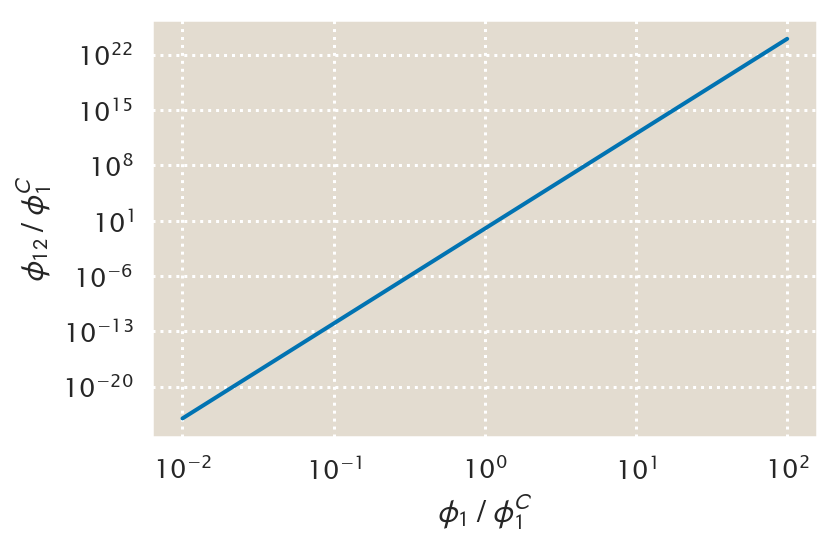

In [19]:
# Define range of fractions to be used for phi_1
phi_1_array = np.logspace(-2, 2, 100) * phi_c / 2

# Compute the volume fraction of the complete capsids
phi_n_array = phi_n(-5, 12, phi_1_array)

# Plot result
plt.loglog(phi_1_array / (phi_c / 2), phi_n_array / (phi_c / 2))

# Label axis
plt.xlabel(r'$\phi_1 \; / \; \phi_1^C$')
plt.ylabel(r'$\phi_{12} \; / \; \phi_1^C $')

# Save figure
plt.tight_layout()
plt.savefig(figdir + 'problem_09_05_02.png', bbox_inches='tight')